In [ ]:
!pip install tensorflow-io

     |████████████████████████████████| 22.7 MB 1.5 MB/s 
     |████████████████████████████████| 2.3 MB 60.6 MB/s 


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 679 kB 8.5 MB/s 


In [ ]:
# Importing the necessary libraries
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
import pandas as pd  
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import label_ranking_average_precision_score
import tensorflow_hub as hub

In [ ]:
# Global variables 
img_ht = 384
img_wt = 768
srate=48000
class_n=24
num_mels=384
f_min=40
f_max=24000
batch_size=8
num_steps=140

In [ ]:
train_tp=pd.read_csv('/content/drive/MyDrive/Appliedai files/Case_Study_2/train_tp.csv')

In [ ]:
#train_test_split
X_train,X_cv=train_test_split(train_tp, stratify=train_tp['species_id'], test_size=0.10)

In [ ]:
test=os.listdir('/content/drive/MyDrive/Appliedai files/Case_Study_2/test/')

In [ ]:
X_train.reset_index(inplace=True)
X_cv.reset_index(inplace=True)

In [ ]:
#https://www.tensorflow.org/io/tutorials/audio?hl=pt

def create_mel_spectrogram(file):
    """ This function reads the file and computes the mel spectrogram and returns the spectrogram"""
    audio = tfio.IOTensor.graph(tf.int16).from_audio(file)
    audio_slice = audio[100:]

    # remove last dimension
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    audio_tensor = tf.cast(audio_tensor, tf.float32)

    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=2048, window=2048, stride=512)

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=srate, mels=num_mels, fmin=f_min, fmax=f_max)

    # Convert to db scale mel-spectrogram
    mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # Expanding the dimensions of spectrograms by 1 
    image = tf.expand_dims(mel_spectrogram, axis= -1)
    # Resizing the spectrogram
    image = tf.image.resize(image, [img_ht,img_wt])
    # Converting the spectrogram to rgb
    image = tf.image.grayscale_to_rgb(image)

    # Returning mel_spectrogram
    return image



In [ ]:
#https://www.tensorflow.org/tutorials/images/data_augmentation

def augmentation(spectrogram, label):
    """In this function we resize the image and perform data augumentations for train data"""

    # Getting a random value and based on the random value computing the augmentation
    a = np.random.uniform()
    if a<0.25:
        # Flipping the spectrogram up to down
        spectrogram = tf.image.flip_up_down(spectrogram)
    elif a<0.5:
      spectrogram = tf.image.flip_left_right(spectrogram)
    elif a<0.75:
        # Adding a random contrast to spectrogram
        spectrogram = tf.image.random_contrast(spectrogram, 0.2,0.5)
    else:
        # Adding a random brightness to spectrogram
        spectrogram = tf.image.random_brightness(spectrogram,0.2)

    # Returning the spectrogram image
    return spectrogram, label

In [ ]:
def preprocess_train(file):
    """Preprocessing train files"""
    
    image = create_mel_spectrogram('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')
    
    # Computing the one hot encoded values of species_id
    label = tf.one_hot(file['species_id'], class_n)
    # Returning the spectrogram and one hot encoded species_id
    return image, label


def preprocess_val(file):
    """Preprocessing validation files"""
    image = create_mel_spectrogram('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')

    # Computing the one hot encoded values of species_id
    label = tf.one_hot(file['species_id'], class_n)
    # Returning the spectrogram and one hot encoded species_id
    return image, label

    
def preprocess_test(file):
    """Preprocessing test files"""
    image = create_mel_spectrogram('/content/drive/MyDrive/Appliedai files/Case_Study_2/test/'+file)

    file_name = tf.strings.split(file,'.')[0]
    # Returning only the spectrogram image for test dataset 
    return image, file_name

In [ ]:
# Creating a dataset from train data and mapping the preprocess train function 
files_ds = tf.data.Dataset.from_tensor_slices(dict(X_train))
train_dataset = files_ds.map(preprocess_train).cache().map(augmentation).shuffle(3).batch(batch_size).prefetch(-1).repeat()

# Creating a dataset from train data and mapping the preprocess train function 
files_ds = tf.data.Dataset.from_tensor_slices(dict(X_cv))
val_dataset = files_ds.map(preprocess_val).cache().shuffle(3).batch(batch_size).prefetch(-1)

files_ds = tf.data.Dataset.from_tensor_slices(test)
test_dataset = files_ds.map(preprocess_test).cache().shuffle(3).prefetch(-1)

In [ ]:
def lwlrap(y_true,y_score):
  return tf.py_function(label_ranking_average_precision_score, (y_true,y_score), tf.double)

In [ ]:
backbone = tf.keras.applications.EfficientNetB2(include_top = False,input_shape = (img_ht,img_wt,3), weights="imagenet")
for layer in backbone.layers[:0]:
    layer.trainable = False

model_1 = tf.keras.Sequential([
            backbone,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(class_n,bias_initializer=tf.keras.initializers.Constant(-2.))])

model_1.summary()

model_1.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=2e-3,total_steps=65*140,warmup_proportion=0.3,min_lr=1e-6), loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits = True), metrics=[lwlrap])

31793152/31790344 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 12, 24, 1408)      7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               360704    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                6168      
Total params: 8,136,465
Trainable params: 8,068,378
Non-t

In [ ]:
#loading tensorboard
%load_ext tensorboard
!rm -rf ./logs/
from datetime import datetime
#creating log directory
logdir="logs/scalars_1/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard callback
tensorboard_1 = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#lr_decay=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_lwlrap',factor=0.1, patience=5, mode='max')
earlystop=tf.keras.callbacks.EarlyStopping(monitor='val_lwlrap',patience=15,mode='max')

#Path for saving model
filepath="/content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-{epoch:02d}-{val_lwlrap:.4f}.hdf5"
#Model checkpoint callback
checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_lwlrap', save_best_only=True, verbose=1, mode='max', save_freq='epoch')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
model_fit_1=model_1.fit(train_dataset,steps_per_epoch=num_steps,validation_data=val_dataset,epochs=65,callbacks=[earlystop,tensorboard_1,checkpoint_1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/65
140/140 [==============================] - 157s 699ms/step - loss: 0.9282 - lwlrap: 0.1581 - val_loss: 0.6058 - val_lwlrap: 0.1567

Epoch 00001: val_lwlrap improved from -inf to 0.15669, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-01-0.1567.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/65
140/140 [==============================] - 90s 640ms/step - loss: 0.7609 - lwlrap: 0.2008 - val_loss: 0.5692 - val_lwlrap: 0.1498

Epoch 00002: val_lwlrap did not improve from 0.15669
Epoch 3/65
140/140 [==============================] - 90s 642ms/step - loss: 0.5901 - lwlrap: 0.2292 - val_loss: 0.6058 - val_lwlrap: 0.1783

Epoch 00003: val_lwlrap improved from 0.15669 to 0.17829, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-03-0.1783.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/65
140/140 [==============================] - 91s 647ms/step - loss: 0.4683 - lwlrap: 0.2895 - val_loss: 0.6219 - val_lwlrap: 0.2096

Epoch 00004: val_lwlrap improved from 0.17829 to 0.20958, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-04-0.2096.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/65
140/140 [==============================] - 90s 642ms/step - loss: 0.4212 - lwlrap: 0.3169 - val_loss: 1.0833 - val_lwlrap: 0.2523

Epoch 00005: val_lwlrap improved from 0.20958 to 0.25235, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-05-0.2523.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/65
140/140 [==============================] - 90s 645ms/step - loss: 0.3768 - lwlrap: 0.3868 - val_loss: 0.6379 - val_lwlrap: 0.3623

Epoch 00006: val_lwlrap improved from 0.25235 to 0.36232, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-06-0.3623.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/65
140/140 [==============================] - 90s 642ms/step - loss: 0.3688 - lwlrap: 0.4043 - val_loss: 0.6843 - val_lwlrap: 0.3487

Epoch 00007: val_lwlrap did not improve from 0.36232
Epoch 8/65
140/140 [==============================] - 90s 646ms/step - loss: 0.3498 - lwlrap: 0.4269 - val_loss: 0.5193 - val_lwlrap: 0.3769

Epoch 00008: val_lwlrap improved from 0.36232 to 0.37691, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-08-0.3769.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/65
140/140 [==============================] - 90s 643ms/step - loss: 0.3361 - lwlrap: 0.4735 - val_loss: 0.5355 - val_lwlrap: 0.4788

Epoch 00009: val_lwlrap improved from 0.37691 to 0.47882, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-09-0.4788.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/65
140/140 [==============================] - 90s 644ms/step - loss: 0.3265 - lwlrap: 0.5078 - val_loss: 1.2286 - val_lwlrap: 0.2922

Epoch 00010: val_lwlrap did not improve from 0.47882
Epoch 11/65
140/140 [==============================] - 90s 644ms/step - loss: 0.3304 - lwlrap: 0.4931 - val_loss: 0.6200 - val_lwlrap: 0.3690

Epoch 00011: val_lwlrap did not improve from 0.47882
Epoch 12/65
140/140 [==============================] - 90s 644ms/step - loss: 0.3004 - lwlrap: 0.5426 - val_loss: 1.0183 - val_lwlrap: 0.5494

Epoch 00012: val_lwlrap improved from 0.47882 to 0.54944, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-12-0.5494.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/65
140/140 [==============================] - 90s 645ms/step - loss: 0.2895 - lwlrap: 0.5726 - val_loss: 1.8834 - val_lwlrap: 0.3867

Epoch 00013: val_lwlrap did not improve from 0.54944
Epoch 14/65
140/140 [==============================] - 90s 644ms/step - loss: 0.3078 - lwlrap: 0.5350 - val_loss: 1.3531 - val_lwlrap: 0.4004

Epoch 00014: val_lwlrap did not improve from 0.54944
Epoch 15/65
140/140 [==============================] - 90s 644ms/step - loss: 0.3417 - lwlrap: 0.4904 - val_loss: 2.6133 - val_lwlrap: 0.2859

Epoch 00015: val_lwlrap did not improve from 0.54944
Epoch 16/65
140/140 [==============================] - 90s 644ms/step - loss: 0.3810 - lwlrap: 0.4000 - val_loss: 1.4375 - val_lwlrap: 0.2439

Epoch 00016: val_lwlrap did not improve from 0.54944
Epoch 17/65
140/140 [==============================] - 90s 644ms/step - loss: 0.3357 - lwlrap: 0.4565 - val_loss: 1.0915 - val_lwlrap: 0.4180

Epoch 00017: val_lwlrap did not improve from 0.54944
Epoch 18/65
140/140 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/65
140/140 [==============================] - 90s 641ms/step - loss: 0.2299 - lwlrap: 0.6873 - val_loss: 0.3729 - val_lwlrap: 0.5790

Epoch 00025: val_lwlrap improved from 0.55016 to 0.57896, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-25-0.5790.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 26/65
140/140 [==============================] - 90s 644ms/step - loss: 0.2132 - lwlrap: 0.7209 - val_loss: 0.4276 - val_lwlrap: 0.6329

Epoch 00026: val_lwlrap improved from 0.57896 to 0.63293, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-26-0.6329.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/65
140/140 [==============================] - 90s 644ms/step - loss: 0.2337 - lwlrap: 0.6750 - val_loss: 0.4206 - val_lwlrap: 0.5336

Epoch 00027: val_lwlrap did not improve from 0.63293
Epoch 28/65
140/140 [==============================] - 90s 645ms/step - loss: 0.2179 - lwlrap: 0.7073 - val_loss: 0.3111 - val_lwlrap: 0.5954

Epoch 00028: val_lwlrap did not improve from 0.63293
Epoch 29/65
140/140 [==============================] - 90s 645ms/step - loss: 0.2089 - lwlrap: 0.7335 - val_loss: 0.6078 - val_lwlrap: 0.5167

Epoch 00029: val_lwlrap did not improve from 0.63293
Epoch 30/65
140/140 [==============================] - 90s 644ms/step - loss: 0.2119 - lwlrap: 0.7266 - val_loss: 0.5160 - val_lwlrap: 0.6064

Epoch 00030: val_lwlrap did not improve from 0.63293
Epoch 31/65
140/140 [==============================] - 90s 643ms/step - loss: 0.2131 - lwlrap: 0.7278 - val_loss: 1.2543 - val_lwlrap: 0.5040

Epoch 00031: val_lwlrap did not improve from 0.63293
Epoch 32/65
140/140 

In [ ]:
%tensorboard --logdir /content/logs/scalars_1

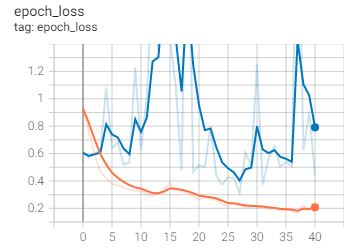

In [ ]:
#Loss and metric plots

from IPython.display import Image
Image(filename='/content/drive/MyDrive/EffnetB2_loss.JPG')

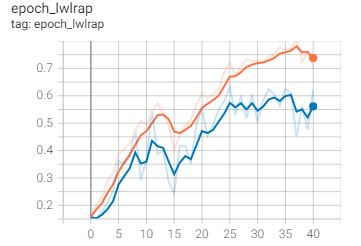

In [ ]:
Image(filename='/content/drive/MyDrive/EffnetB2_metric.JPG')

## CNN and LSTM Models Ensemble

Now we will make an ensemble of all the cnn models trained on spetrogram RGB image and lstm model trained on yamnet embeddings.

## EfficientNetB3

In [ ]:
backbone_2 = tf.keras.applications.EfficientNetB3(include_top = False,input_shape = (img_ht,img_wt,3), weights="imagenet")

for layer in backbone_2.layers[:0]:
    layer.trainable = False

model_2 = tf.keras.Sequential([
            backbone_2,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
            tf.keras.layers.Dropout(0.5),
            #tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(class_n,bias_initializer=tf.keras.initializers.Constant(-2.))])

model_2.summary()

43941888/43941136 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 12, 24, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                3096      
Total params: 10,983,367
Trainable params: 10,896,064
Non-trainable params: 87,303
_________________________________________________________________


### DenseNet121

In [ ]:
backbone_3 = tf.keras.applications.DenseNet121(include_top = False,input_shape = (img_ht,img_wt,3), weights="imagenet")

for layer in backbone_3.layers[:0]:
    layer.trainable = False

model_3 = tf.keras.Sequential([
            backbone_3,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(class_n,bias_initializer=tf.keras.initializers.Constant(-2.))])

model_3.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 12, 24, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                3096      
Total params: 7,172,312
Trainable params: 7,088,408
Non

###LSTM Model with yamnet embeddings


In [ ]:
#Train a NN classifier with embedding features
def lstm_model():

  input_layer= tf.keras.layers.Input(shape=(124,1024), name='Input_layer')
  lstm_layer= tf.keras.layers.LSTM(512,return_sequences=True)(inputs=input_layer)
  td=tf.keras.layers.GlobalAveragePooling1D()(lstm_layer)
  dense_2= tf.keras.layers.Dense(324, activation='relu',kernel_initializer='he_normal')(td)
  drop_out1= tf.keras.layers.Dropout(0.7)(dense_2)
  dense_3= tf.keras.layers.Dense(128, activation='relu',kernel_initializer='he_normal')(drop_out1)
  drop_out2= tf.keras.layers.Dropout(0.5)(dense_3)
  dense_4=tf.keras.layers.Dense(64, activation='relu',kernel_initializer='he_normal')(drop_out2)
  dense_5=tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal')(dense_4)
  output= tf.keras.layers.Dense(class_n, activation='sigmoid')(dense_5)
  model= tf.keras.models.Model(inputs=[input_layer], outputs=[output])

  opt=tf.keras.optimizers.Adam()  # Optimizer
  model.compile(optimizer=opt, loss='binary_crossentropy',metrics=[lwlrap])

  return model
  
model_4=lstm_model()
model_4.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 124, 1024)]       0         
_________________________________________________________________
lstm (LSTM)                  (None, 124, 512)          3147776   
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 324)               166212    
_________________________________________________________________
dropout_3 (Dropout)          (None, 324)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               41600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0     

### Saving all the architectures in json files to use later

In [ ]:
#Serialize models to JSON

model_1_json=model_1.to_json()
model_2_json=model_2.to_json()
model_3_json=model_3.to_json()
model_4_json=model_4.to_json()

with open ('/content/drive/MyDrive/Appliedai files/Case_Study_2/model_1.json','w') as json_file_1:
  json_file_1.write(model_1_json)

with open ('/content/drive/MyDrive/Appliedai files/Case_Study_2/model_2.json','w') as json_file_2:
  json_file_2.write(model_2_json)

with open ('/content/drive/MyDrive/Appliedai files/Case_Study_2/model_3.json','w') as json_file_3:
  json_file_3.write(model_3_json)

with open ('/content/drive/MyDrive/Appliedai files/Case_Study_2/model_4.json','w') as json_file_4:
  json_file_4.write(model_4_json)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Loading the weights

In [ ]:
model_1.load_weights('/content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_6/weights-26-0.6329.hdf5')

In [ ]:
model_2.load_weights('/content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/21-0.9206-0.7486.h5')

In [ ]:
model_3.load_weights('/content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_2/32-0.8647-0.7383.h5')

In [ ]:
model_4.load_weights('/content/drive/MyDrive/Appliedai files/Case_Study_2/model_1/weights-69-0.6032.hdf5')

In [ ]:
yamnet_model_handle= 'https://tfhub.dev/google/yamnet/1'
yamnet_model=hub.load(yamnet_model_handle)

In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.
def load_flac_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    #audio,sr=librosa.load(filename,mono=True,sr=16000)
    audio = tfio.IOTensor.graph(tf.int16).from_audio(filename)
    audio_slice = audio.to_tensor()

    # remove last dimension
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    audio_tensor = tf.cast(audio_tensor, tf.float32)
    sample_rate = tf.cast(48000, dtype=tf.int64)
    audio_tensor = tfio.audio.resample(audio_tensor, rate_in=sample_rate, rate_out=16000)

    scores, embeddings, spectrogram = yamnet_model(audio_tensor)
    return embeddings
  

In [ ]:
def preprocess_embed_train(file):
    """Preprocessing train files"""
    # Calling the preprocess_img function with data_type as train
    
    audio = load_flac_16k_mono('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')
    
    # Computing the one hot encoded values of species_id
    label = tf.one_hot(file['species_id'], CLASS_N)
    # Returning the spectrogram and one hot encoded species_id
    return audio,label


def preprocess_embed_val(file):
    """Preprocessing validation files"""
    # Calling the preprocess_img function with data_type as validation
    audio = load_flac_16k_mono('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')

    # Computing the one hot encoded values of species_id
    label = tf.one_hot(file['species_id'], CLASS_N)
    # Returning the spectrogram and one hot encoded species_id
    return audio, label

    
def preprocess_embed_test(file):
    """Preprocessing test files"""
    # Calling the preprocess_img function with data_type as test
    audio = load_flac_16k_mono('/content/drive/MyDrive/Appliedai files/Case_Study_2/test/'+file)

    file_name = tf.strings.split(file,'.')[0]
    # Returning only the spectrogram image for test dataset 
    return audio,file_name


In [ ]:
#Dataset for LSTM yamnet model
# Creating a dataset from train data and mapping the preprocess train function 
files_ds_tr = tf.data.Dataset.from_tensor_slices(dict(X_train))
train_embed_dataset = files_ds_tr.map(preprocess_embed_train).cache().prefetch(-1)

# Creating a dataset from train data and mapping the preprocess train function 
files_ds_val = tf.data.Dataset.from_tensor_slices(dict(X_cv))
val_embed_dataset = files_ds_val.map(preprocess_embed_val).cache().prefetch(-1)

files_ds = tf.data.Dataset.from_tensor_slices(test)
test_embed_dataset = files_ds.map(preprocess_embed_test).cache().prefetch(-1)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
#dataset for cnn models

# Creating a dataset from train data and mapping the preprocess train function 
files_ds = tf.data.Dataset.from_tensor_slices(dict(X_train))
train_dataset = files_ds.map(preprocess_train).cache().prefetch(-1)

# Creating a dataset from train data and mapping the preprocess train function 
files_ds = tf.data.Dataset.from_tensor_slices(dict(X_cv))
val_dataset = files_ds.map(preprocess_val).cache().prefetch(-1)

files_ds = tf.data.Dataset.from_tensor_slices(test)
test_dataset = files_ds.map(preprocess_test).cache().prefetch(-1)

In [ ]:
cnn_models=[model_1,model_2,model_3]

In [ ]:
from tqdm import tqdm
def ensemble_predictions(cnn_models,cnn_dataset,rnn_model,rnn_dataset):

  cnn_final_pred=[]
  rnn_final_pred=[]
  final_pred=[]
  cnn_id = []
  rnn_id= []

  for image,file in tqdm(cnn_dataset.batch(1)):
    cnn_id.append(file)
    y_pred = []
    for model in cnn_models:
      #taking the sigmoid of predictions
      pred = tf.sigmoid(model(image)).numpy()
      y_pred.append(pred)
    y_pred=np.asarray(y_pred)
    #Taking the mean of predictions
    mean_pred=np.mean(y_pred,axis=0)
    cnn_final_pred.append(mean_pred)
  #predictions from lstm model
  for embed,file in tqdm(rnn_dataset.batch(1)):
    rnn_id.append(file)
    rnn_pred=rnn_model.predict(embed)
    rnn_final_pred.append(rnn_pred)
  

  #combining CNN and lstm predictions and taking mean
  for i,j in zip(cnn_final_pred,rnn_final_pred):
    pred_list=[]
    pred_list.append(i)
    pred_list.append(j)
    pred_list=np.asarray(pred_list)
    mean_final_pred=np.mean(pred_list,axis=0)
    final_pred.append(mean_final_pred)

  return final_pred,cnn_id,rnn_id

In [ ]:
ensemble_train_pred,cnn_label,rnn_label=ensemble_predictions(cnn_models,train_dataset,model_4,train_embed_dataset)

100%|██████████| 1094/1094 [00:46<00:00, 23.47it/s]


In [ ]:
ensemble_val_pred,cnn_val_label,rnn_val_label=ensemble_predictions(cnn_models,val_dataset,model_4,val_embed_dataset)

100%|██████████| 122/122 [00:05<00:00, 22.53it/s]


####Predictions on train data

In [ ]:
train_pred=np.asarray(ensemble_train_pred,dtype='float16')
train_pred=train_pred.reshape(1094,24)

y_train=[]
for i in rnn_label:
  k=i.numpy()
  y_train.append(k)

y_train=np.asarray(y_train)
y_train=y_train.reshape(1094,24)

train_lwlrap=lwlrap(y_train,train_pred)

print(train_lwlrap)

tf.Tensor(0.9219465482719601, shape=(), dtype=float64)


#### Predictions on Validation data

In [ ]:
val_pred=np.asarray(ensemble_val_pred,dtype='float16')
val_pred=val_pred.reshape(122,24)

y_val=[]
for a in rnn_val_label:
  b=a.numpy()
  y_val.append(a)

y_val=np.asarray(y_val)
y_val=y_val.reshape(122,24)

val_lwlrap=lwlrap(y_val,val_pred)

print(val_lwlrap)

tf.Tensor(0.9387978142076502, shape=(), dtype=float64)


#### Predictions on test set

In [ ]:
ensemble_test_pred,test_cnn_id,test_rnn_id=ensemble_predictions(cnn_models,test_dataset,model_4,test_embed_dataset)

100%|██████████| 1992/1992 [26:04<00:00,  1.27it/s]


In [ ]:
test_pred=np.asarray(ensemble_test_pred,dtype='float16')
test_pred=test_pred.reshape(1992,24)

In [ ]:
column_names=[]

for i in range(24):
  column_names.append('s'+str(i))

df_index=[i for i in range(1992)]

test_recording_id=[]
for i in test_cnn_id:
  k=i.numpy()
  k=str(k)
  test_recording_id.append(k[3:-2])


results_df=pd.DataFrame(data=test_pred,index=df_index,columns=column_names)

results_df['recording_id']=test_recording_id

In [ ]:
new_results=results_df.reindex(columns=['recording_id','s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18',
                            's19','s20','s21','s22','s23'])

new_results.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,7c712b45f,0.020950,0.019745,0.045044,0.130615,0.019867,0.059845,0.041656,0.121643,0.022766,0.059692,0.103210,0.051575,0.022217,0.008789,0.017929,0.061035,0.029968,0.184326,0.016876,0.160034,0.111267,0.036407,0.110413,0.205078
1,7d064b789,0.580566,0.017273,0.022385,0.037415,0.024078,0.022461,0.015388,0.013199,0.033112,0.018295,0.010406,0.018234,0.540527,0.024139,0.010475,0.018387,0.021347,0.026672,0.070618,0.014130,0.009529,0.015404,0.012573,0.009727
2,7cfaed5a0,0.368896,0.040527,0.021652,0.076477,0.055756,0.042267,0.025284,0.031799,0.068542,0.048004,0.021408,0.026871,0.628418,0.022491,0.026764,0.026840,0.032928,0.031311,0.160645,0.015839,0.030930,0.034943,0.035187,0.030182
3,7d188d367,0.156860,0.022995,0.026627,0.084473,0.093323,0.034973,0.028503,0.034332,0.062744,0.053802,0.011795,0.044769,0.358643,0.021683,0.021347,0.021225,0.018967,0.018768,0.356934,0.020782,0.032928,0.036591,0.022888,0.025757
4,7df2eb324,0.011520,0.016373,0.016357,0.059418,0.021469,0.028305,0.141235,0.031281,0.023315,0.178833,0.045929,0.046661,0.033295,0.010803,0.015556,0.024429,0.021820,0.314453,0.014832,0.049652,0.057404,0.029495,0.025238,0.390625


In [ ]:
new_results.to_csv('/content/drive/MyDrive/Appliedai files/Case_Study_2/submission_8.csv',index=False)

Converting models to TFLite format for deployement

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model_1 = converter.convert()
open ('/content/drive/MyDrive/Appliedai files/Case_Study_2/model_1.tflite' , 'wb') .write(tflite_quant_model_1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp4apmohk7/assets


9332848

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model_2 = converter.convert()
open ('/content/drive/MyDrive/Appliedai files/Case_Study_2/model_2.tflite' , 'wb') .write(tflite_quant_model_2)

converter = tf.lite.TFLiteConverter.from_keras_model(model_3)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model_3 = converter.convert()
open ('/content/drive/MyDrive/Appliedai files/Case_Study_2/model_3.tflite' , 'wb') .write(tflite_quant_model_3)

converter = tf.lite.TFLiteConverter.from_keras_model(model_4)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model_4 = converter.convert()
open ('/content/drive/MyDrive/Appliedai files/Case_Study_2/model_4.tflite' , 'wb') .write(tflite_quant_model_4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpyoqm510a/assets


INFO:tensorflow:Assets written to: /tmp/tmpyoqm510a/assets


INFO:tensorflow:Assets written to: /tmp/tmplgg5fm1y/assets


INFO:tensorflow:Assets written to: /tmp/tmplgg5fm1y/assets


INFO:tensorflow:Assets written to: /tmp/tmpap4fzgyl/assets


INFO:tensorflow:Assets written to: /tmp/tmpap4fzgyl/assets


3651088

## Results

In [1]:
!pip install prettytable

In [2]:
from prettytable import PrettyTable
summary = PrettyTable()
summary.field_names = ["Model", "lrap"]
summary.add_row(["EfficientNetB2",0.632])
summary.add_row(["EfficientNetB3", 0.748])
summary.add_row(["DenseNet121", 0.738])
summary.add_row(["LSTM", 0.603])
summary.add_row(["Ensemble Model", 0.938])
print(summary)

+----------------+-------+
|     Model      |  lrap |
+----------------+-------+
| EfficientNetB2 | 0.632 |
| EfficientNetB3 | 0.748 |
|  DenseNet121   | 0.738 |
|      LSTM      | 0.603 |
| Ensemble Model | 0.938 |
+----------------+-------+
